In [99]:
words = open('names.txt', 'r', encoding='utf-8').read().splitlines()
print(words[-3:])
print(len(words))

['zyrie', 'zyron', 'zzyzx']
32033


In [100]:
letters = sorted(list(set(''.join(words)))) # Get all individual letters sorted, should be alphabet (if all letters are once included in our names)
num_of_unique_letters = len(letters) + 1 # Add 1 for '.' our special char
stoi = {s:i+1 for i,s in enumerate(letters)} # Create a mapping from a char to a int in order to index in tensor
stoi['.'] = 0 # Add . as a special char
itos = {i:s for s,i in stoi.items()} # Create the mapping in reverse
print(num_of_unique_letters)
print(letters)

27
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [101]:
def build_data(words, nChars):
    x, y = [], []
    for w in words:
        chs = list('.'*nChars + w + ".")
        chs = [stoi[c] for c in chs]
        for i in range(len(chs)-nChars):
            x.append(chs[i:i+nChars])
            y.append(chs[i+nChars])
    return (x,y)

# Example 'zuzanna' becomes training example (.. -> z, ..z -> u, and so on until last nna -> .) and chars are converted to the ints

nChars = 3
print(words[-1:])
print(build_data(words[-1:], nChars))

['zzyzx']
([[0, 0, 0], [0, 0, 26], [0, 26, 26], [26, 26, 25], [26, 25, 26], [25, 26, 24]], [26, 26, 25, 26, 24, 0])


In [102]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
g = torch.Generator().manual_seed(2147483647)

random.shuffle(words)
trainIdx = int(0.8*len(words))
valIdx = int(0.9*len(words))

xTrain, yTrain = build_data(words[0:trainIdx], nChars)
xTrain = torch.tensor(xTrain)
yTrain = torch.tensor(yTrain)

xVal, yVal = build_data(words[trainIdx:valIdx], nChars)
xVal = torch.tensor(xVal)
yVal = torch.tensor(yVal)

xTest, yTest = build_data(words[valIdx:], nChars)
xTest = torch.tensor(xTest)
yTest = torch.tensor(yTest)


nC = 5 # Look up table, can also be seen as the first layer to our network
nHiddenN = 100 # Size of hidden layer

C = torch.randn((num_of_unique_letters, nC), generator=g)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = torch.nn.Linear(nC*nChars, nHiddenN, bias=False)
        self.bn1 = torch.nn.BatchNorm1d(nHiddenN)
        self.tanh1 = torch.nn.Tanh()
        
        self.l2 = torch.nn.Linear(nHiddenN, nHiddenN, bias=False)
        self.bn2 = torch.nn.BatchNorm1d(nHiddenN)
        self.tanh2 = torch.nn.Tanh()
        
        self.l3 = torch.nn.Linear(nHiddenN, nHiddenN, bias=False)
        self.bn3 = torch.nn.BatchNorm1d(nHiddenN)
        self.tanh3 = torch.nn.Tanh()
        
        self.l4 = torch.nn.Linear(nHiddenN, nHiddenN, bias=False)
        self.bn4 = torch.nn.BatchNorm1d(nHiddenN)
        self.tanh4 = torch.nn.Tanh()

        self.l5 = torch.nn.Linear(nHiddenN, num_of_unique_letters, bias=False)
        self.bn5 = torch.nn.BatchNorm1d(num_of_unique_letters)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.bn1(x)
        x = self.tanh1(x)
        
        x = self.l2(x)
        x = self.bn2(x)
        x = self.tanh2(x)
        
        x = self.l3(x)
        x = self.bn3(x)
        x = self.tanh3(x)
        
        x = self.l4(x)
        x = self.bn4(x)
        x = self.tanh4(x)
        
        x = self.l5(x)
        x = self.bn5(x)
        return x
    
net = Net()

loss_fn = F.cross_entropy
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

trL = []
vaL = []

In [104]:
iterations = 100_000
batch_size = 32

for iter in range(iterations):

    # minibatch construct
    mIdx = torch.randint(0, xTrain.shape[0], (batch_size,))
    
    # forward pass
    emb = C[xTrain[mIdx]] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    x = net.forward(x)
    loss = loss_fn(x, yTrain[mIdx]) # loss function

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update
    optimizer.step()

    # track stats
    if iter % 5_000 == 0: # print every once in a while
        with torch.no_grad():
            Yb = yVal
            emb = C[xVal]
            x = emb.view(emb.shape[0], -1)
            x = net(x)
            vaLoss = loss_fn(x, Yb)
            vaL.append(loss.log10().item())

            print(f'{iter:7d}/{iterations:7d}: tr: {loss.item():.4f}, va: {vaLoss.item():.4f}')
        
    trL.append(loss.log10().item())



      0/ 100000: tr: 3.6671, va: 3.6050
   5000/ 100000: tr: 2.8810, va: 2.3110
  10000/ 100000: tr: 1.9870, va: 2.2681
  15000/ 100000: tr: 1.7342, va: 2.2468
  20000/ 100000: tr: 2.3544, va: 2.2195
  25000/ 100000: tr: 2.1642, va: 2.2085
  30000/ 100000: tr: 2.0849, va: 2.2003
  35000/ 100000: tr: 2.0772, va: 2.1908
  40000/ 100000: tr: 2.4374, va: 2.1893
  45000/ 100000: tr: 2.2373, va: 2.1799
  50000/ 100000: tr: 1.9527, va: 2.1765
  55000/ 100000: tr: 2.1546, va: 2.1776
  60000/ 100000: tr: 2.2750, va: 2.1693
  65000/ 100000: tr: 2.2737, va: 2.1727
  70000/ 100000: tr: 1.9112, va: 2.1648
  75000/ 100000: tr: 1.8466, va: 2.1598
  80000/ 100000: tr: 2.0339, va: 2.1619
  85000/ 100000: tr: 2.2467, va: 2.1570
  90000/ 100000: tr: 2.0483, va: 2.1528
  95000/ 100000: tr: 1.8521, va: 2.1541


In [105]:
# Theoretical first loss should be around:
-torch.tensor([1/27]).log()

tensor([3.2958])

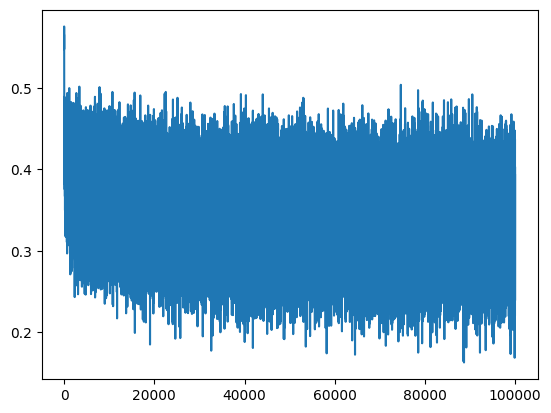

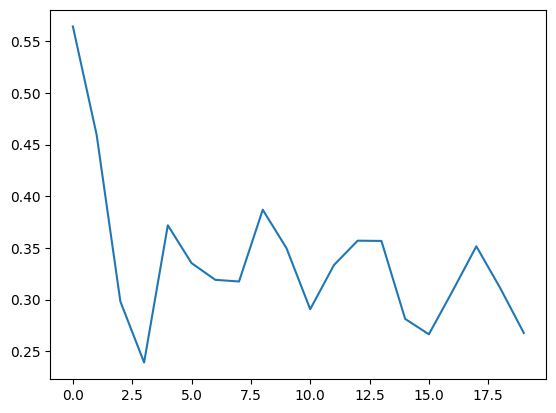

In [106]:
plt.plot(trL)
plt.show()
plt.plot(vaL)

In [107]:
net.eval()

with torch.no_grad():
    for _ in range(10):
        curr_context = list('.'*nChars)
        name = []

        while True:
            # Run 1 forward with the current context of word
            chs = torch.tensor([stoi[c] for c in curr_context])
            emb = C[chs] # embed the characters into vectors

            x = net.forward(emb.view(1, -1))

            # Sample from the output and convert that int to a char
            sample = torch.multinomial(F.softmax(x, dim=1), 1)
            next_char = itos[sample.item()]

            curr_context = curr_context[1:] + [next_char]
            name.append(next_char)

            # End
            if next_char == '.':
                break

        print(''.join(x for x in name)[:-1])

br
adixa
ana
jasestoric
sea
bick
ellynn
arigalianna
lar
naylienna
